In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#**Cargar datos**

In [ ]:
data = pd.read_csv('')
print(len(data))
data.head()

13951


Fecha y Hora  Altura_rp39  Altura_rn14  GYCH  BGYC  \
0  2022-02-02 12:00:00        5.160         3.78  0.96  0.80   
1  2022-02-02 13:00:00        5.135         3.78  0.96  0.78   
2  2022-02-02 14:00:00        5.110         3.79  0.94  0.76   
3  2022-02-02 15:00:00        5.085         3.80  0.92  0.76   
4  2022-02-02 20:00:00        4.960         3.81  0.86  0.70   

   Velocidad_viento_wind_guru_nandubaysal  \
0                                     7.0   
1                                     6.0   
2                                     6.0   
3                                     5.0   
4                                     9.0   

   Direccion_viento_wind_guru_nandubaysal  Lluvia_wind_guru_nandubaysal  \
0                                   209.0                           0.0   
1                                   212.0                           0.0   
2                                   221.0                           0.0   
3                                   239.0                           0.0   
4                                   271.0                           0.0   

   Velocidad_viento_wind_guru_san_justo  Direccion_viento_wind_guru_san_justo  \
0                                   7.0                                 229.0   
1                                   7.0                                 235.0   
2                                   6.0                                 250.0   
3                                   6.0                                 274.0   
4                                  10.0                                 289.0   

   Lluvia_wind_guru_san_justo  Altura_nueva_palmira  Bloque  
0                         0.0                 0.465       1  
1                         0.0                 0.435       1  
2                         0.0                 0.395       1  
3                         0.0                 0.370       1  
4                         0.0                 0.610       2

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
col = data.columns.values.tolist()
col.remove('Fecha y Hora')
col.remove('Bloque')
normalized_data = data.copy()
normalized_data[col] = scaler.fit_transform(normalized_data[col])
normalized_data.head()

Fecha y Hora  Altura_rp39  Altura_rn14      GYCH      BGYC  \
0  2022-02-02 12:00:00     0.533063     0.381531  0.202703  0.180412   
1  2022-02-02 13:00:00     0.529690     0.381531  0.202703  0.175258   
2  2022-02-02 14:00:00     0.526316     0.382746  0.198198  0.170103   
3  2022-02-02 15:00:00     0.522942     0.383961  0.193694  0.170103   
4  2022-02-02 20:00:00     0.506073     0.385176  0.180180  0.154639   

   Velocidad_viento_wind_guru_nandubaysal  \
0                                0.225806   
1                                0.193548   
2                                0.193548   
3                                0.161290   
4                                0.290323   

   Direccion_viento_wind_guru_nandubaysal  Lluvia_wind_guru_nandubaysal  \
0                                0.582173                           0.0   
1                                0.590529                           0.0   
2                                0.615599                           0.0   
3                                0.665738                           0.0   
4                                0.754875                           0.0   

   Velocidad_viento_wind_guru_san_justo  Direccion_viento_wind_guru_san_justo  \
0                                  0.28                              0.637883   
1                                  0.28                              0.654596   
2                                  0.24                              0.696379   
3                                  0.24                              0.763231   
4                                  0.40                              0.805014   

   Lluvia_wind_guru_san_justo  Altura_nueva_palmira  Bloque  
0                         0.0              0.150662       1  
1                         0.0              0.140728       1  
2                         0.0              0.127483       1  
3                         0.0              0.119205       1  
4                         0.0              0.198675       2

In [ ]:
val_blocks = [35, 79, 91]

train_size = int(0.65 * len(normalized_data))

train_data = normalized_data[:train_size]
train_data = train_data[~train_data['Bloque'].isin(val_blocks)].copy()

test_data = normalized_data[train_size:]
test_data = test_data[~test_data['Bloque'].isin(val_blocks)].copy()

val_data = data.loc[data['Bloque'].isin(val_blocks)].copy()

print(len(train_data))
print(len(test_data))
print(len(val_data))

7992
2883
3076


In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, df, input_cols, target_cols, lookback):
    self.df = df
    self.input_cols = input_cols
    self.target_cols = target_cols
    self.lookback = lookback
    self.valid_indices = self.generate_valid_indices()

  def generate_valid_indices(self):
    valid_indices = []

    for _, group in self.df.groupby('Bloque'):
      if len(group) >= self.lookback + 1:
        valid_indices.extend(group.index[:-self.lookback])
    return valid_indices

  def __len__(self):
    return len(self.valid_indices)

  def __getitem__(self, index):
    start_idx = self.valid_indices[index]
    end_idx = start_idx + self.lookback - 1
    x = self.df.loc[start_idx:end_idx][self.input_cols].values.astype('float32')

    y = self.df.loc[start_idx+1:end_idx+1][self.target_cols].values.astype('float32')

    block = self.df.loc[start_idx, 'Bloque']

    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), block

#**Modelo**

In [ ]:
class CustomLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=1):
    super(CustomLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

  def forward(self, x, h_c=None):
    if h_c[0] is not None:
      out, (h, c) = self.lstm(x, h_c)
    else:
      out, (h, c) = self.lstm(x)
    return out, (h, c)

In [ ]:
from collections import OrderedDict

class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_sizes, num_layers, output_dim, dropout=0.2):
    super(LSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_sizes = hidden_sizes
    self.output_dim = output_dim
    self.dropout = dropout
    self.lstm_layers, self.dropout_layers = self.stack_layers()
    self.linear = nn.Linear(hidden_sizes[-1], output_dim)

  def stack_layers(self):
    lstm_layers = nn.ModuleList()
    dropout_layers = nn.ModuleList()

    for i, h in enumerate(self.hidden_sizes):
      in_size = self.input_size if i == 0 else self.hidden_sizes[i-1]
      lstm_layers.append(CustomLSTM(in_size, h))
      if i < len(self.hidden_sizes) - 1:
        dropout_layers.append(nn.Dropout(self.dropout))

    return lstm_layers, dropout_layers


  def forward(self, x, initial_states=None):
    batch_size = x.size(0)
    seq_len = x.size(1)
    final_states = []

    if initial_states is None:
      initial_states =[]
      for i, h_size in enumerate(self.hidden_sizes):
        h0 = torch.zeros(1, batch_size, h_size, device=x.device, dtype=x.dtype)
        c0 = torch.zeros(1, batch_size, h_size, device=x.device, dtype=x.dtype)
        initial_states.append((h0, c0))

    current_layer_input = x

    for i, lstm_layer in enumerate(self.lstm_layers):
      layer_initial_state = initial_states[i]

      layer_output, (h_f, c_f) = lstm_layer(current_layer_input, layer_initial_state)
      final_states.append((h_f, c_f))

      if i < len(self.lstm_layers) - 1:
        next_layer_input = self.dropout_layers[i](layer_output)
      else:
        next_layer_input = layer_output

      current_layer_input = next_layer_input

    x = self.linear(current_layer_input)

    return x, final_states

#**Auxiliares**

In [ ]:
class EarlyStopping():
  def __init__(self, patience=10, min_delta=0.0001):

      self.patience = patience
      self.min_delta = min_delta
      self.best_average_loss = None
      self.counter = 0
      self.early_stop = False
      self.best_model_state = None

  def __call__(self, val_loss, model):
    score = -val_loss
    if self.best_average_loss is None:
      self.best_average_loss = score
      self.best_model_state = model.state_dict()
    elif score < self.best_average_loss + self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_average_loss = score
      self.counter = 0
      self.best_model_state = model.state_dict()

  def load_best_model(self, model):
    model.load_state_dict(self.best_model_state)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

class ErrorInfo():
  def __init__(self, data, target_columns):
    self.best_training_mse = float('inf')
    self.mse_training_tensor = None #Tensor (batch_size, lookback, output_dim) correspondinte al mejor valor de pérdida
    self.bias_training = None #Tensor (batch_size, lookback, output_dim) correspondinte al mejor valor de pérdida

    self.mse_validation = None #Dataframe
    self.bias_validation = None #Dataframe

    self.scaler = MinMaxScaler().fit(data[target_columns])

    self.target_columns = target_columns


  def evaluate_training_mse(self, mse_value, mse_training_tensor, bias_values):
    if mse_value < self.best_training_mse:
      self.best_training_mse = mse_value
      self.mse_training_tensor = self.denormalize_tensor(mse_training_tensor)
      self.bias_training = self.denormalize_tensor(bias_values)

  def validation_mse(self, mse_validation, bias_values):
    self.mse_validation = mse_validation
    self.bias_validation = bias_values

  def denormalize_tensor(self, tensor):

    tensor = tensor.detach().cpu().numpy()
    matrix = tensor.reshape(-1, tensor.shape[2])
    denormalized_matrix = self.scaler.inverse_transform(matrix)
    tensor = denormalized_matrix.reshape(tensor.shape)
    tensor = torch.tensor(tensor, dtype=torch.float32)
    return tensor

  def get_mse(self):
    training_cols = [f'MSE_training_{col}' for col in self.target_columns]
    training_mean = self.mse_training_tensor.mean(dim=(0,1)).tolist()
    round_mean_training = [round(x, 5) for x in training_mean]
    training_df = pd.DataFrame([round_mean_training], columns=training_cols)

    validation_cols = [f'MSE_validation_{col}' for col in self.target_columns]
    validation_mean = self.mse_validation.mean().values.tolist()
    round_mean_validation = [round(x, 5) for x in validation_mean]
    validation_df = pd.DataFrame([round_mean_validation], columns=validation_cols)

    return pd.concat([training_df, validation_df], axis=1)


  def get_bias(self):
    training_cols = [f'BIAS_training_{col}' for col in self.target_columns]
    training_mean = self.bias_training.mean(dim=(0,1)).tolist()
    round_mean_training = [round(b, 5) for b in training_mean]
    training_df = pd.DataFrame([round_mean_training], columns=training_cols)

    validation_cols = [f'BIAS_validation_{col}' for col in self.target_columns]
    validation_mean = self.bias_validation.mean().values.tolist()
    round_mean_validation = [round(b, 5) for b in validation_mean]
    validation_df = pd.DataFrame([round_mean_validation], columns=validation_cols)

    return pd.concat([training_df, validation_df], axis=1)

  def get_error_info(self):
    return pd.concat([self.get_mse(), self.get_bias()], axis=1)

In [ ]:
class Trainer():
  def __init__(self, model, train_loader, test_loader, loss_fn, optimizer, early_stopping, scheduler, num_epochs, device, error_info):
    self.model = model
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.early_stopping = early_stopping
    self.scheduler = scheduler
    self.num_epochs = num_epochs
    self.device = device
    self.error_info = error_info
    self.train_hist = []
    self.test_hist = []
    self.evaluations = []
    self.plots = {}

  def train(self):
    for epoch in range(self.num_epochs):
          total_loss = 0.0
          self.model.train()
          #Inicializar estado oculto
          current_hidden_states = None
          last_block = None
          for batch_x, batch_y, batch_blocks_ids in self.train_loader:
              batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
              batch_block_ids = batch_blocks_ids.to(self.device)

              current_batch_first_block_id = batch_block_ids[0]
              if last_block is None or current_batch_first_block_id != last_block: #Si se cambia de bloque temporal, se reinicia el estado oculto
                  current_hidden_states = None
              elif current_hidden_states is not None: #Si no se cambia de bloque temporal, se actualiza el estado oculto
                current_hidden_states = [(h.to(self.device), c.to(self.device)) for h, c in current_hidden_states]

              self.optimizer.zero_grad()
              y_pred, new_hidden_states = self.model(batch_x, current_hidden_states)

              tensor_loss = self.loss_fn(y_pred, batch_y)

              loss = tensor_loss.mean()
              with torch.no_grad():
                bias = (y_pred - batch_y)
              self.error_info.evaluate_training_mse(loss.item(), tensor_loss, bias)

              loss.backward()

              self.optimizer.step()

              total_loss += loss.item()

              current_hidden_states = [(h.detach(), c.detach()) for h, c in new_hidden_states]

              last_block = batch_block_ids[-1].item()

          average_loss = total_loss / len(self.train_loader)
          self.train_hist.append(average_loss)

          self.model.eval()

          current_test_hidden_states = None
          last_block_test = None
          with torch.no_grad():
              total_test_loss = 0.0

              for batch_x_test, batch_y_test, batch_test_block_ids in self.test_loader:
                  batch_x_test, batch_y_test = batch_x_test.to(self.device), batch_y_test.to(self.device)
                  batch_test_block_ids = batch_test_block_ids.to(self.device)

                  current_test_batch_first_block_id = batch_test_block_ids[0].item()

                  if last_block_test is None or current_test_batch_first_block_id != last_block_test:
                      current_test_hidden_states = None
                  elif current_test_hidden_states is not None:
                    current_test_hidden_states = [(h.to(self.device), c.to(self.device)) for h, c in current_test_hidden_states]



                  predictions_test, new_test_hidden_states = self.model(batch_x_test, current_test_hidden_states)

                  test_loss = self.loss_fn(predictions_test, batch_y_test).mean()
                  total_test_loss += test_loss.item()

                  current_test_hidden_states = [(h.detach(), c.detach()) for h, c in new_test_hidden_states]

                  last_block_test = batch_test_block_ids[-1]

              average_test_loss = total_test_loss / len(self.test_loader)
              self.test_hist.append(average_test_loss)

          self.scheduler.step(test_loss)
          self.early_stopping(average_test_loss, model)
          if self.early_stopping.early_stop:
              print(f"Deteniendo entrenamiento\nEpoch: {epoch + 1}.\nNo hay mejora en {self.early_stopping.patience} épocas.")
              break

          if (epoch + 1) % 10 == 0:
              print(f'Epoch [{epoch + 1}/{self.num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

    self.early_stopping.load_best_model(model)

  def plot_training(self):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(self.train_hist, label="Training Loss")
    ax.plot(self.test_hist, label="Test Loss")
    ax.set_xlabel("Épocas")
    ax.set_ylabel("Loss")
    ax.set_title("Evolución de la pérdida durante el entrenamiento")
    ax.legend()
    plt.show()
    self.plots['training_loss'] = fig

  def evaluate_on_training(self):
    self.model.eval()
    predictions = []
    actual_values = []
    current_hidden_states = None
    last_block = None

    with torch.no_grad():
        for batch_x_test, batch_y_test, batch_block_ids in self.test_loader:
            batch_x_test, batch_y_test = batch_x_test.to(self.device), batch_y_test.to(self.device)
            batch_block_ids = batch_block_ids.to(self.device)


            current_batch_first_block_id = batch_block_ids[0].item()
            if last_block is None or current_batch_first_block_id != last_block:
                current_hidden_states = None
            elif current_hidden_states is not None:
                current_hidden_states = [(h.to(self.device), c.to(self.device)) for h, c in current_hidden_states]


            y_pred_test, new_hidden_states = self.model(batch_x_test, current_hidden_states)

            predictions.append(y_pred_test[:, -1, :].cpu().numpy())
            actual_values.append(batch_y_test[:, -1, :].cpu().numpy())

            current_hidden_states = [(h.detach(), c.detach()) for h, c in new_hidden_states]
            last_block = batch_block_ids[-1].item()

    predictions = np.concatenate(predictions, axis=0)
    actual_values = np.concatenate(actual_values, axis=0)
    self.evaluations.append(predictions)
    self.evaluations.append(actual_values)


  def plot_evaluation_training(self, target_columns):
    predictions = self.evaluations[0]
    actual_values = self.evaluations[1]

    for i, var in enumerate(target_columns):
      fig, ax = plt.subplots(figsize=(8, 5))

      ax.plot(actual_values[:, i], label='Real', linestyle='None', marker='x')
      ax.plot(predictions[:, i], label=f'Predicted')
      ax.legend()
      ax.set_title(f'Variable {var}')
      ax.set_xlabel('Tiempo')
      plt.show()
      self.plots[f'evaluation_{var}'] = fig

In [ ]:
import os

class ModelInfo():
  def __init__(self, model, propuesta, batch_size, error_info, lookback, hidden_sizes, dropout, shuffle, plots):
    self.model = model
    self.excel_path = '' # Hoja de resultados
    self.df = None
    self.id = self.get_id()
    self.propuesta = propuesta
    self.batch_size = batch_size
    self.error_info = error_info
    self.lookback = lookback
    self.hidden_sizes = hidden_sizes
    self.dropout = dropout
    self.error_info = error_info
    self.shuffle = shuffle
    self.plots = plots
    self.folder_path = f'' # Guardar plots
    self.create_folder()
    self.create_df()
    self.column_order = ['ID', 'Propuesta', 'Capas LSTM', 'Neuronas por capa', 'Lookback', 'Dropout', 'Batch', 'Shuffle',
                         'MSE_training_BGYC', 'BIAS_training_BGYC', 'MSE_training_GYCH', 'BIAS_training_GYCH', 'MSE_training_Altura_rp39','BIAS_training_Altura_rp39',
                         'MSE_training_Altura_rn14', 'BIAS_training_Altura_rn14', 'MSE_validation_BGYC', 'BIAS_validation_BGYC', 'MSE_validation_GYCH', 'BIAS_validation_GYCH',
                         'MSE_validation_Altura_rp39', 'BIAS_validation_Altura_rp39', 'MSE_validation_Altura_rn14', 'BIAS_validation_Altura_rn14']

  def get_id(self):
    old_models = pd.read_excel(self.excel_path)
    try:
      max_id = old_models['ID'].max()
      return max_id + 1
    except:
      return 1

  def create_folder(self):
    folder_path = f'' # Carpeta del modelo por id
    os.makedirs(folder_path, exist_ok=True)

  def create_df(self):
    self.df = pd.DataFrame([[self.id, self.propuesta, len(self.hidden_sizes), str(self.hidden_sizes), self.lookback, self.dropout, self.batch_size, self.shuffle]],
                           columns=['ID', 'Propuesta', 'Capas LSTM', 'Neuronas por capa', 'Lookback', 'Dropout', 'Batch', 'Shuffle'])
    self.df = pd.concat([self.df, self.error_info.get_error_info()], axis=1)

  def save_info(self):
    old_models = pd.read_excel(self.excel_path)
    all_models = pd.concat([old_models, self.df])
    self.df = all_models
    all_models.to_excel(self.excel_path, index=False)

  def save_plots(self):
    for name, fig in self.plots.items():
      fig.savefig(f'{self.folder_path}/{name}_{self.id}.png')

  def save_model(self):
    torch.save({
      'model_state_dict': self.model.state_dict(),
      'model_params': {
          'input_size': input_size,
          'hidden_sizes': hidden_sizes,
          'num_layers': num_layers,
          'output_dim': output_dim,
          'dropout': dropout,
      },
      'info': self.df.iloc[-1]
    }, f'{self.folder_path}/modelo_{self.id}.pt')

  def prepare_heatmap(self, metric_type):
    df = self.df.copy()
    drop_cols = ['ID', 'Propuesta', 'Batch', 'Dropout', 'Capas LSTM']
    drop_cols += [c for c in df.columns if (
        ('MSE' in c if metric_type == 'BIAS' else 'BIAS' in c) or 'training' in c)]
    df = df.drop(columns=drop_cols).copy()

    # Formato de campos de configuración
    df['Lookback'] = df['Lookback'].astype(str).map(lambda x: f"Lb={x}")
    df['Shuffle'] = df['Shuffle'].map({True: 'Sh=T', False: 'Sh=F'})
    df['Index'] = df.apply(
        lambda row: f"{row['Neuronas por capa']} | {row['Shuffle']} | {row['Lookback']}", axis=1)

    df.set_index('Index', inplace=True)
    df.drop(columns=['Neuronas por capa', 'Shuffle', 'Lookback'], inplace=True)

    # Renombrar columnas
    df.columns = [f"{c[:len(metric_type)]}_{c[-4:]}" for c in df.columns]
    return df

  def plot_heatmap(self):
    d_mse = self.prepare_heatmap(metric_type='MSE')
    d_bias = self.prepare_heatmap(metric_type='BIAS')

    fig, axs = plt.subplots(1, 2, figsize=(11, len(d_bias)*0.6))

    for ax, data, title in zip(axs, [d_mse, d_bias], ["MSE", "BIAS"]):
      if title == "MSE":
        im = ax.imshow(data.values, cmap="inferno", vmin=0)
      else:
        v = max(abs(d_bias.values.min()), abs(d_bias.values.max()))
        im = ax.imshow(d_bias.values, cmap="berlin", vmin=-v, vmax=v)
      ax.set_title(title)
      ax.set_xticks(range(len(data.columns)))
      ax.set_xticklabels(data.columns, rotation=40, ha="right")
      ax.set_yticks(range(len(data.index)))
      ax.set_yticklabels(data.index)

      for i in range(len(data.columns)):
          for j in range(len(data.index)):
              ax.text(i, j, round(data.iloc[j, i], 2), ha="center", va="center", color="w")

      cbar = fig.colorbar(im, ax=ax)
      cbar.ax.set_ylabel('', rotation=-90, va="bottom")

    plt.subplots_adjust(wspace=0.3)
    plt.show()
    return fig

  def save_all(self):
    self.save_info()
    self.save_plots()
    self.save_model()
    heatmap = self.plot_heatmap()
    heatmap.savefig(f'') # Guardar heatmap
    print(f'Modelo {self.id} guardado')

#**Predicciones**

In [ ]:
class Validator():
  def __init__(self, validation_data, lookback, target_columns, device):
    self.validation_data = validation_data
    self.val_blocks = val_data['Bloque'].unique()
    self.lookback = lookback
    self.target_columns = target_columns
    self.pred_dfs = {}
    self.mse_validation = pd.DataFrame(columns=self.target_columns)
    self.bias_validation = pd.DataFrame(columns=self.target_columns)
    self.plots = {}
    self.device = device

  def validate(self):
    for val_block in self.val_blocks:
      data_predict = self.validation_data.loc[self.validation_data['Bloque'] == val_block].drop(columns=['Fecha y Hora', 'Bloque']).copy().reset_index(drop=True)
      pred_df = pd.DataFrame(columns=self.target_columns)
      hidden = None


      for i in range(self.lookback, len(data_predict)):

          if i > self.lookback:
            d = data_predict.copy()
            for target_column in self.target_columns:
                d.loc[pred_df.index, target_column] = pred_df[target_column]
            d = d.iloc[i-lookback: i].copy()
          else:
            d = data_predict.iloc[i - self.lookback:i].copy()

          prediction, hidden = predict(d, self.device, hidden)

          prediction = prediction.tail(1)
          prediction.set_index(pd.Index([i]), inplace=True)
          pred_df = pd.concat([pred_df, prediction])



      self.pred_dfs[val_block] = pred_df.copy()

      bias = pred_df - data_predict[target_columns][lookback:].reset_index(drop=True)
      mse = (pred_df - data_predict[target_columns][lookback:].reset_index(drop=True))**2

      self.mse_validation = pd.concat([self.mse_validation, mse], ignore_index=True)
      self.bias_validation = pd.concat([self.bias_validation, bias], ignore_index=True)

  def plot_validation(self):
    for val_block in self.val_blocks:
      for i, var in enumerate(self.target_columns):
        fig, ax = plt.subplots(figsize=(8, 5))

        data_predict = self.validation_data.loc[self.validation_data['Bloque'] == val_block].drop(columns=['Fecha y Hora', 'Bloque']).copy().reset_index(drop=True)

        ax.plot(data_predict[var], label='Real')
        ax.plot(range(self.lookback, self.lookback + len(self.pred_dfs[val_block][var])), self.pred_dfs[val_block][var], label='Predicted')


        for x in range(24, len(data_predict[var]), 24):
            plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)

        ax.legend()
        ax.set_title(f'Variable {var}\nBloque de validación: {val_block}')
        ax.set_xlabel('Tiempo')
        plt.show()
        self.plots[f'validation_{val_block}_{var}'] = fig

In [ ]:
from sklearn.preprocessing import MinMaxScaler
input_columns = ['Altura_rp39', 'Altura_rn14', 'GYCH', 'BGYC', 'Velocidad_viento_wind_guru_nandubaysal', 'Direccion_viento_wind_guru_nandubaysal', 'Lluvia_wind_guru_nandubaysal',
                 'Velocidad_viento_wind_guru_san_justo', 'Direccion_viento_wind_guru_san_justo', 'Lluvia_wind_guru_san_justo', 'Altura_nueva_palmira']
target_columns = ['BGYC', 'GYCH', 'Altura_rp39', 'Altura_rn14']


def predict(values, device, hidden_state=None):
  scaler_input = MinMaxScaler().fit(data[input_columns])

  scaler_output = MinMaxScaler().fit(data[target_columns])

  values = scaler_input.transform(values)
  values = pd.DataFrame(values, columns=input_columns)

  values = torch.tensor([values.values.tolist()], dtype=torch.float32).to(device)

  with torch.no_grad():
    pred, new_hidden = model(values, hidden_state)

  pred = pred.cpu()
  pred = pred[0].detach().numpy()
  pred = scaler_output.inverse_transform(pred)
  pred = pd.DataFrame(pred, columns=target_columns)
  return pred, new_hidden

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 256


input_columns = ['Altura_rp39', 'Altura_rn14', 'GYCH', 'BGYC', 'Velocidad_viento_wind_guru_nandubaysal', 'Direccion_viento_wind_guru_nandubaysal', 'Lluvia_wind_guru_nandubaysal',
                 'Velocidad_viento_wind_guru_san_justo', 'Direccion_viento_wind_guru_san_justo', 'Lluvia_wind_guru_san_justo', 'Altura_nueva_palmira']

target_columns = ['BGYC', 'GYCH', 'Altura_rp39', 'Altura_rn14']
lookback = 96

shuffle = True

train_dataset = TimeSeriesDataset(train_data, lookback=lookback, target_cols = target_columns, input_cols = input_columns)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle,drop_last=True)
test_dataset = TimeSeriesDataset(test_data, lookback=lookback, target_cols = target_columns, input_cols = input_columns)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle,drop_last=True)
print(train_dataset[0][0].shape, len(train_dataset))
print(train_dataset[0][1].shape, len(test_dataset))

cuda
torch.Size([96, 11]) 5031
torch.Size([96, 4]) 1914


In [ ]:
models = []

hidden_sizes = [[100,75], [100,50], [50,25]]


input_size = 11
num_layers = 1
output_dim = 4
dropout = 0.3
num_epochs = 5000

for h in hidden_sizes:
  model = LSTMModel(input_size=input_size,
                  hidden_sizes=h,
                  num_layers=num_layers,
                  output_dim=output_dim,
                  dropout=dropout
                  ).to(device)
  models.append(model)

***MODELO ACTUAL***
ModuleList(
  (0): CustomLSTM(
    (lstm): LSTM(11, 100, batch_first=True)
  )
  (1): CustomLSTM(
    (lstm): LSTM(100, 75, batch_first=True)
  )
)
Epoch [10/5000] - Training Loss: 0.0007, Test Loss: 0.0084
Epoch [20/5000] - Training Loss: 0.0005, Test Loss: 0.0055
Epoch [30/5000] - Training Loss: 0.0003, Test Loss: 0.0029
Epoch [40/5000] - Training Loss: 0.0002, Test Loss: 0.0021
Epoch [50/5000] - Training Loss: 0.0002, Test Loss: 0.0018
Epoch [60/5000] - Training Loss: 0.0002, Test Loss: 0.0019
Epoch [70/5000] - Training Loss: 0.0002, Test Loss: 0.0023
Deteniendo entrenamiento
Epoch: 79.
No hay mejora en 30 épocas.


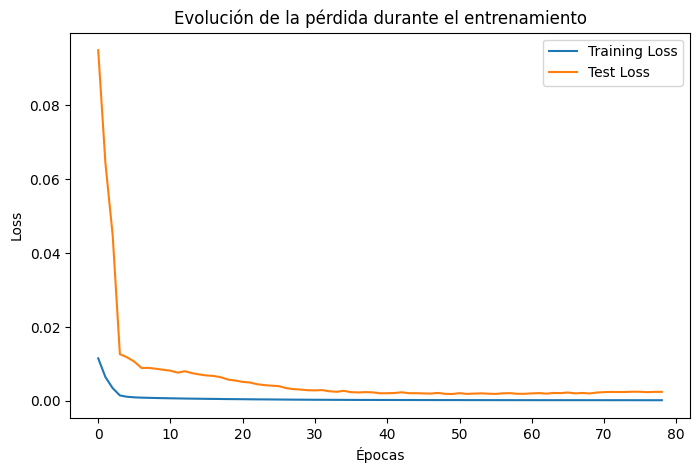

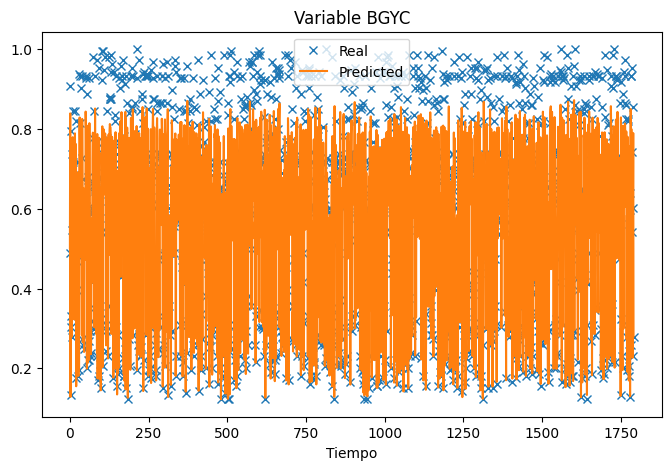

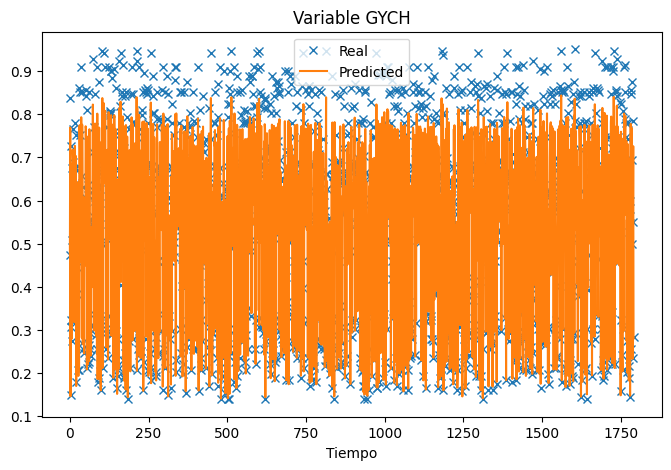

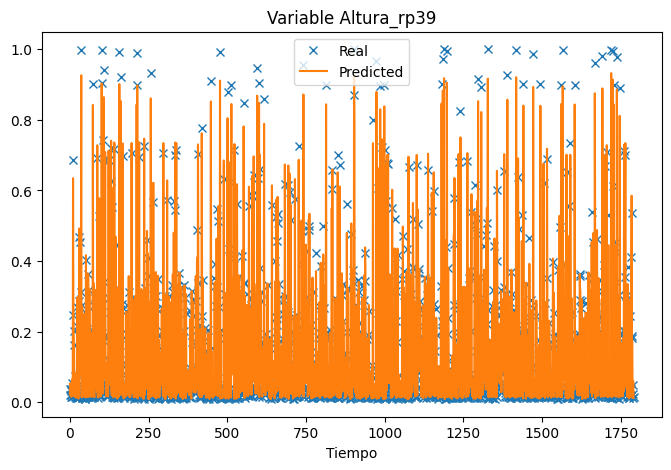

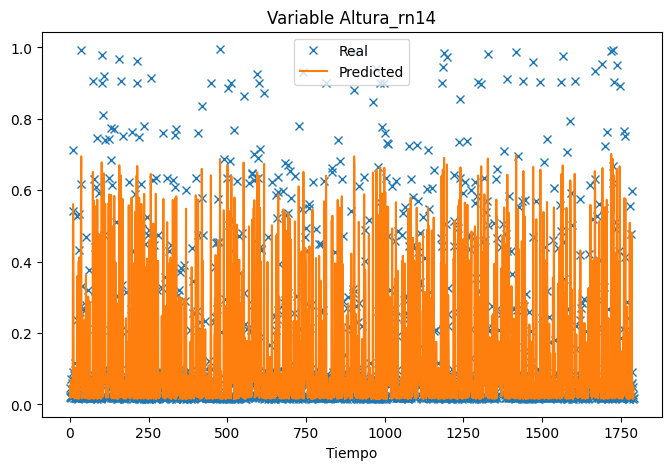

<ipython-input-13-d35cfc7a53fb>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pred_df = pd.concat([pred_df, prediction], ignore_index=True)
<ipython-input-13-d35cfc7a53fb>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.mse_validation = pd.concat([self.mse_validation, mse], ignore_index=True)
<ipython-input-13-d35cfc7a53fb>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or al

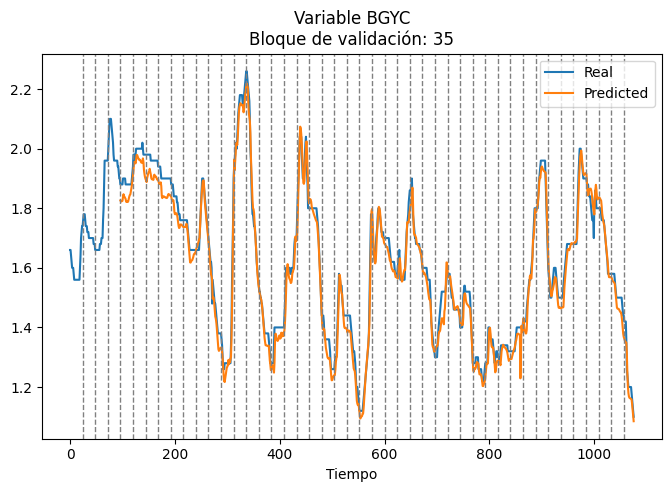

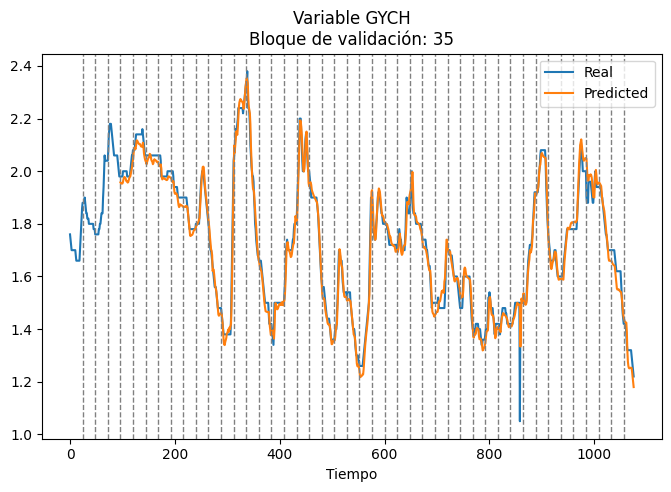

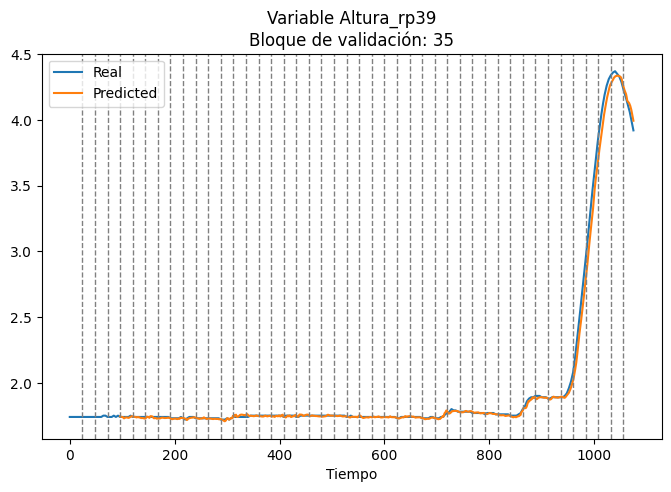

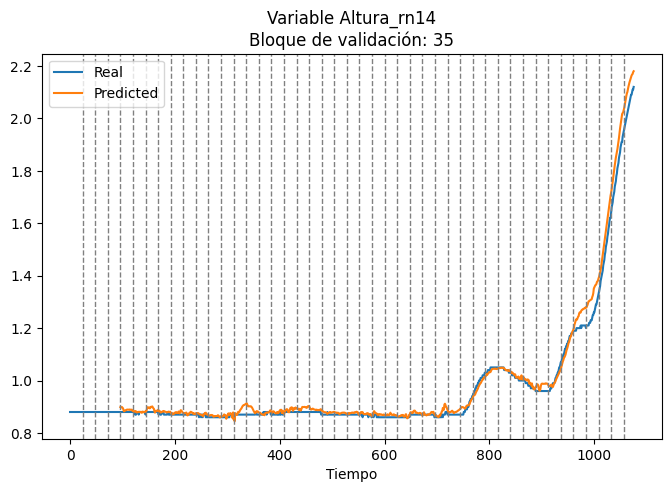

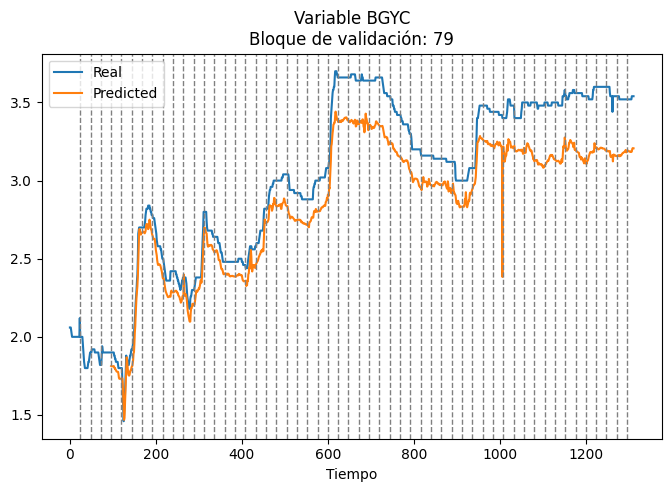

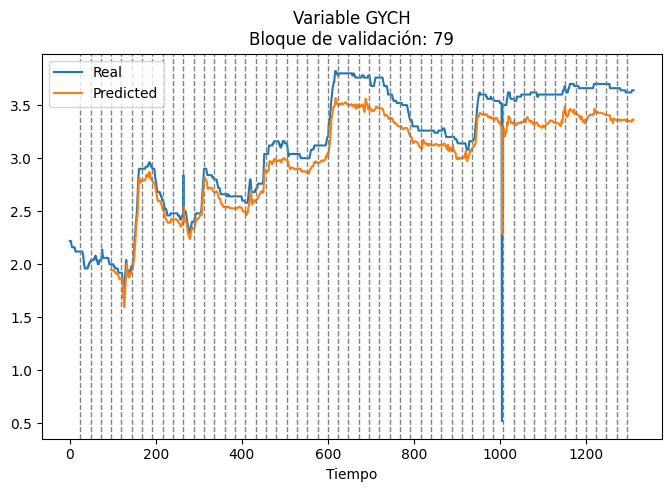

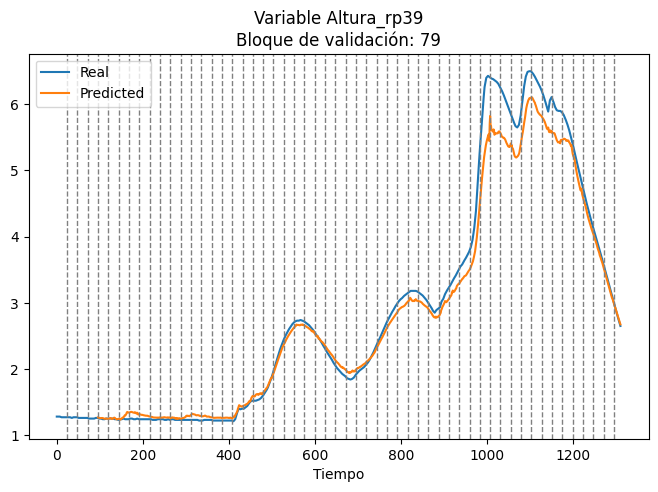

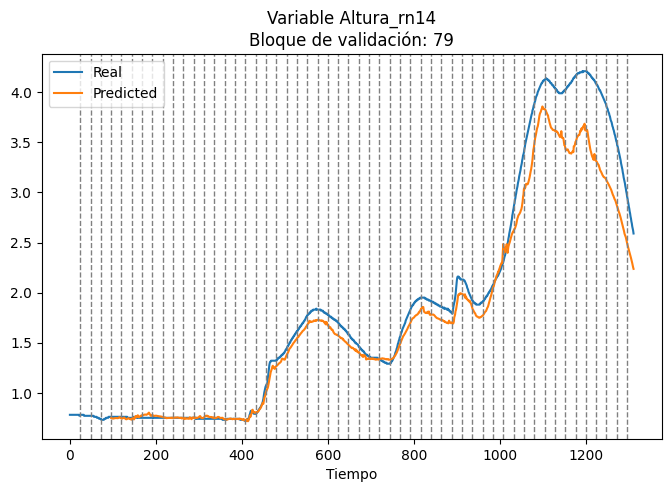

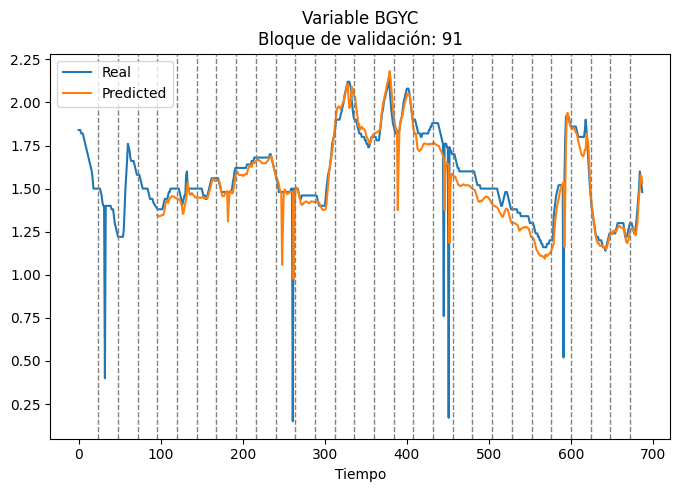

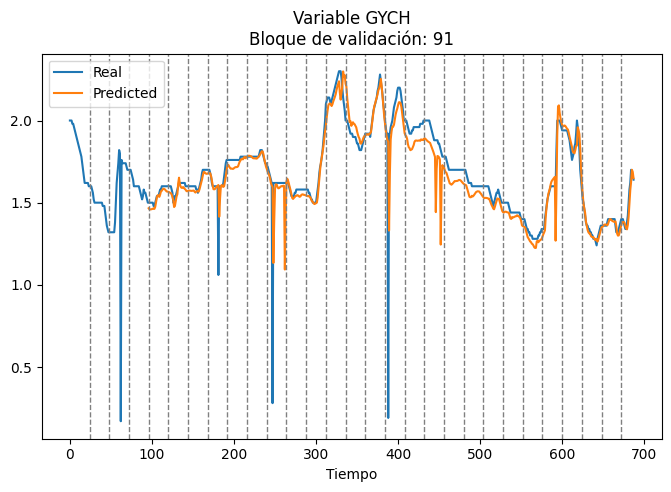

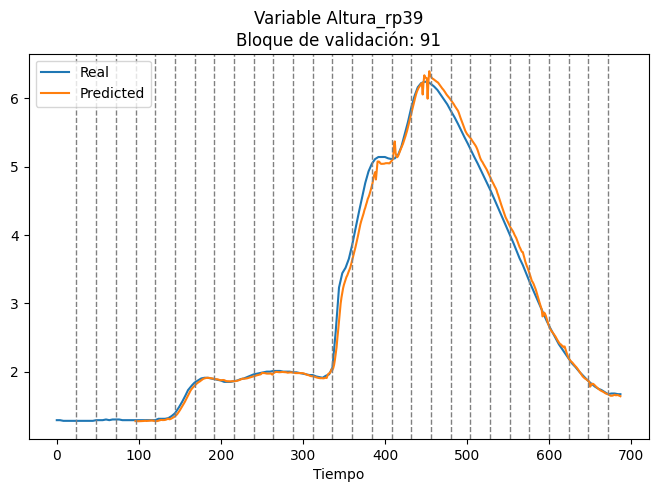

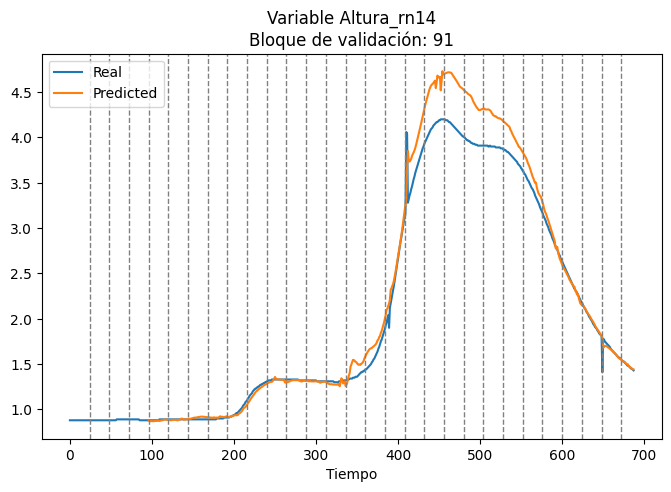

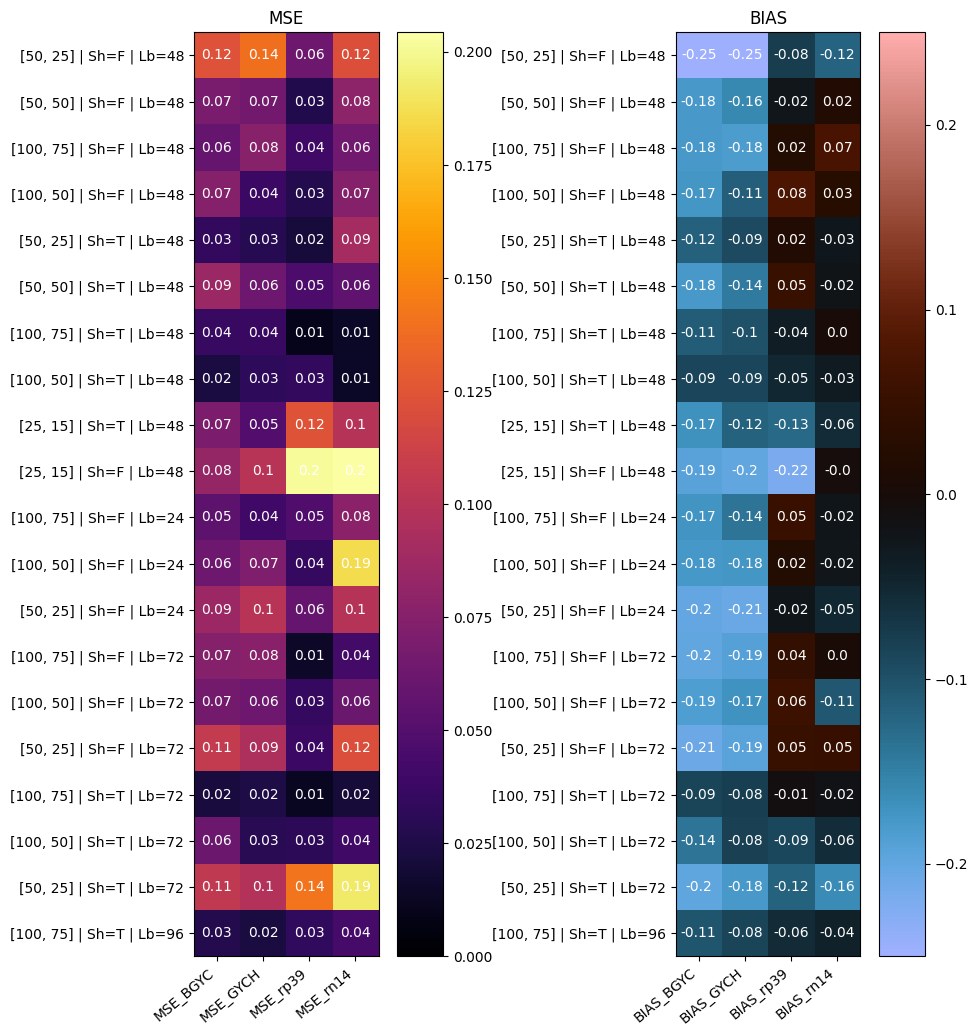

Modelo 20 guardado
***MODELO ACTUAL***
ModuleList(
  (0): CustomLSTM(
    (lstm): LSTM(11, 100, batch_first=True)
  )
  (1): CustomLSTM(
    (lstm): LSTM(100, 50, batch_first=True)
  )
)
Epoch [10/5000] - Training Loss: 0.0011, Test Loss: 0.0076
Epoch [20/5000] - Training Loss: 0.0007, Test Loss: 0.0061
Epoch [30/5000] - Training Loss: 0.0005, Test Loss: 0.0045
Epoch [40/5000] - Training Loss: 0.0003, Test Loss: 0.0035
Epoch [50/5000] - Training Loss: 0.0002, Test Loss: 0.0033
Epoch [60/5000] - Training Loss: 0.0002, Test Loss: 0.0034
Epoch [70/5000] - Training Loss: 0.0002, Test Loss: 0.0035
Deteniendo entrenamiento
Epoch: 76.
No hay mejora en 30 épocas.


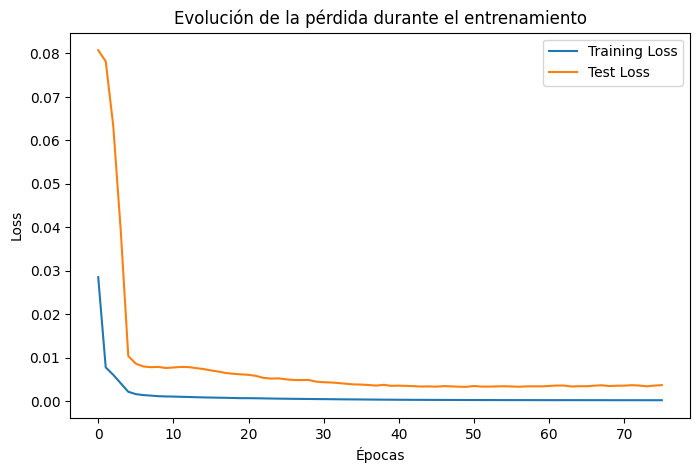

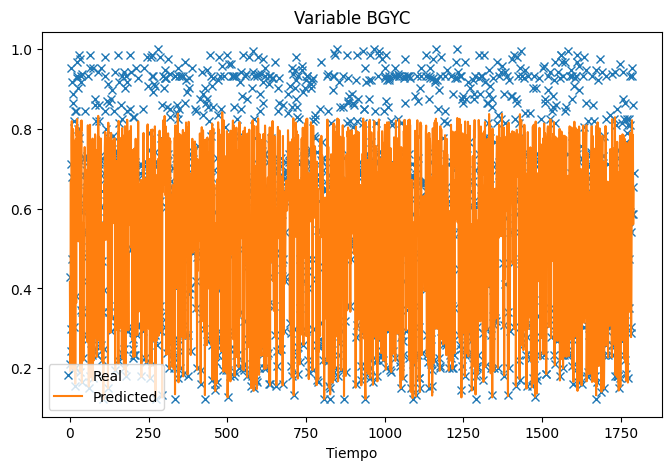

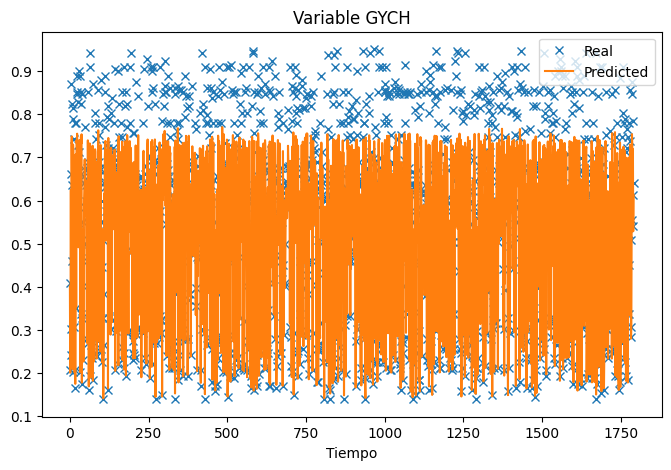

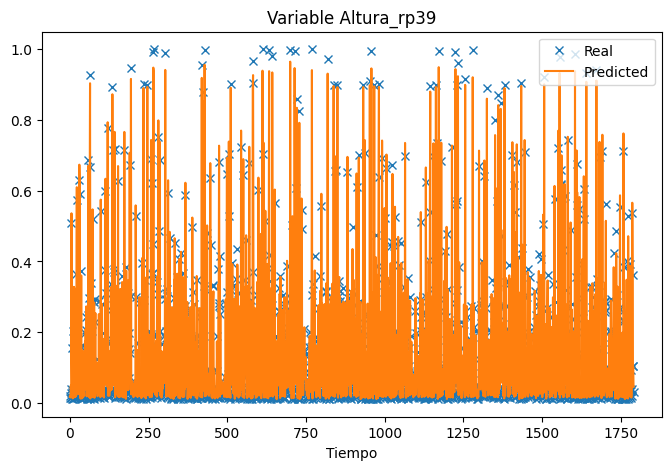

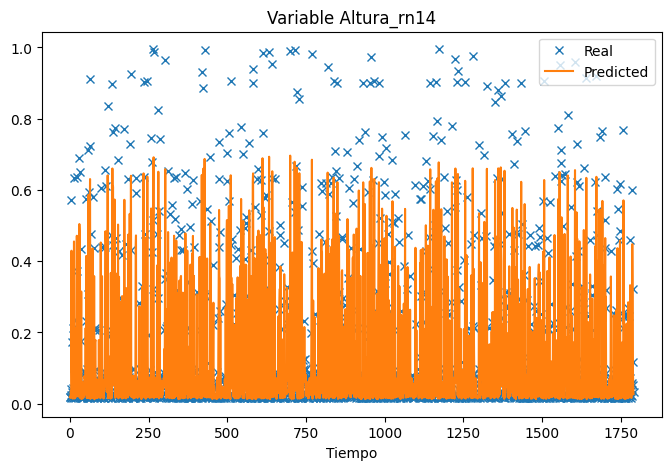

<ipython-input-13-d35cfc7a53fb>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pred_df = pd.concat([pred_df, prediction], ignore_index=True)
<ipython-input-13-d35cfc7a53fb>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.mse_validation = pd.concat([self.mse_validation, mse], ignore_index=True)
<ipython-input-13-d35cfc7a53fb>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or al

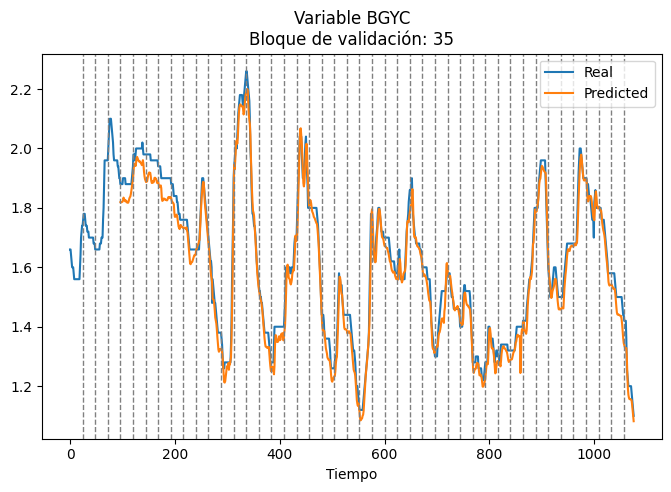

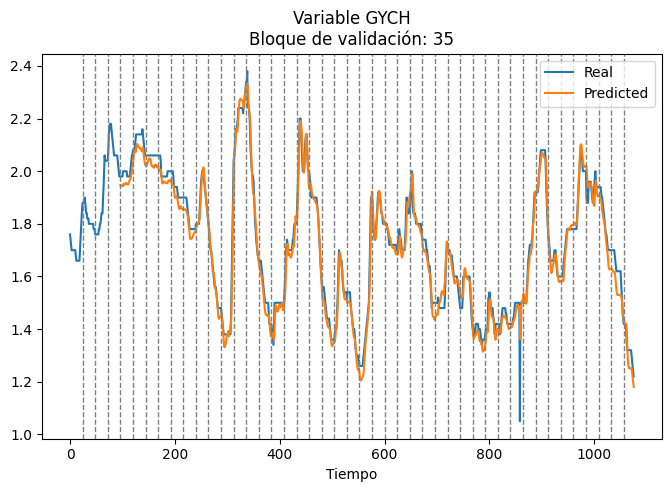

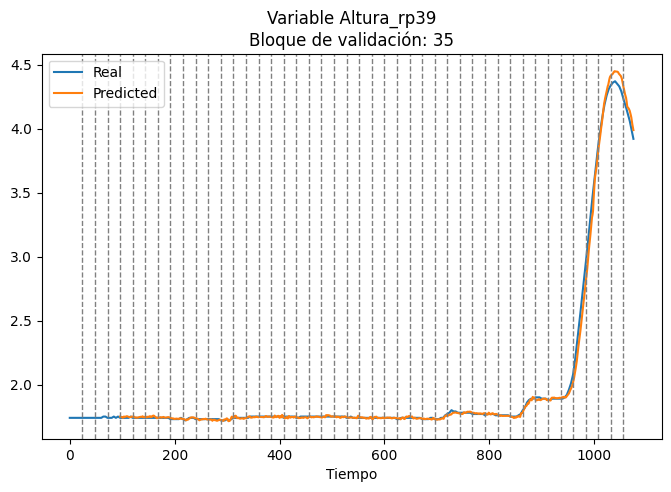

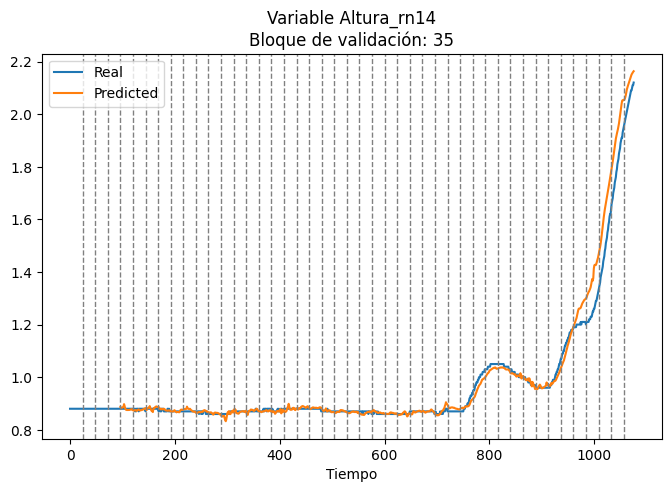

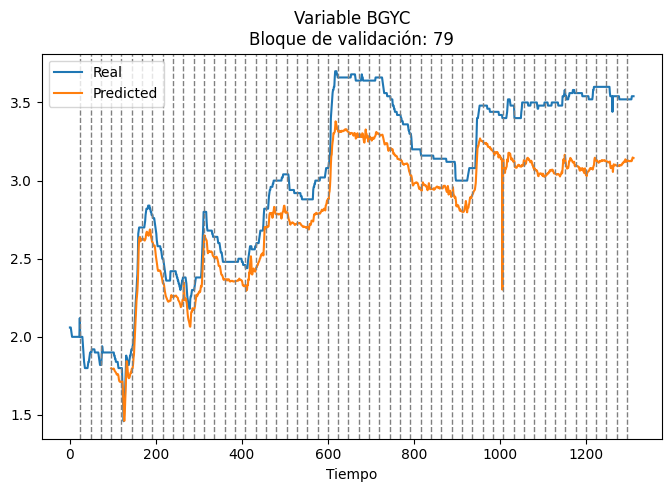

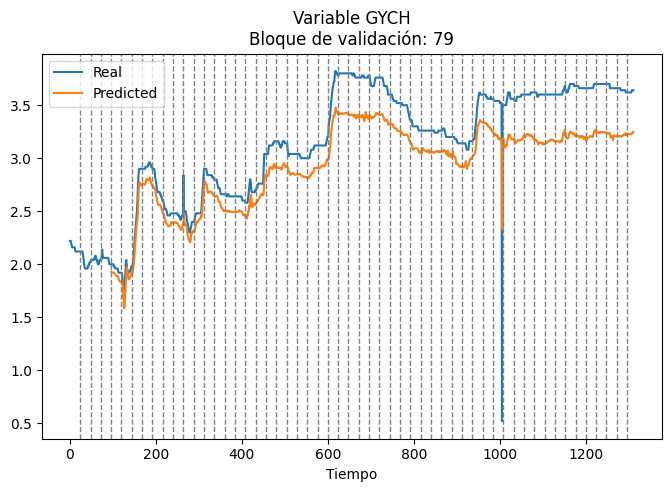

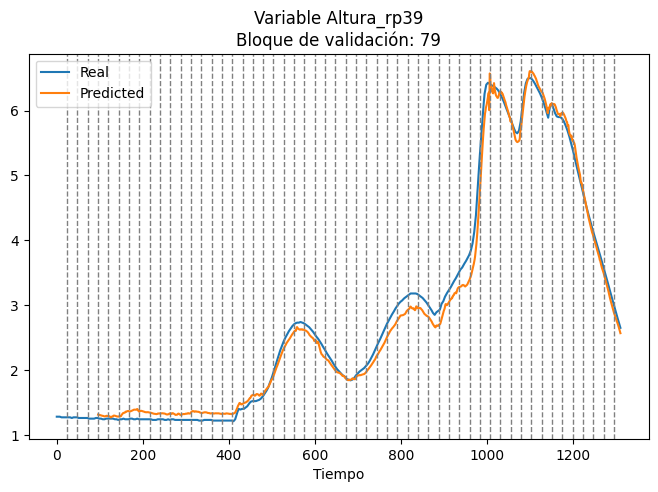

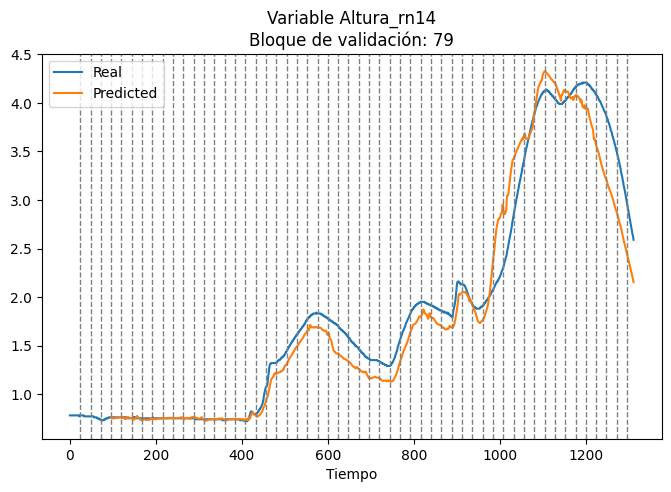

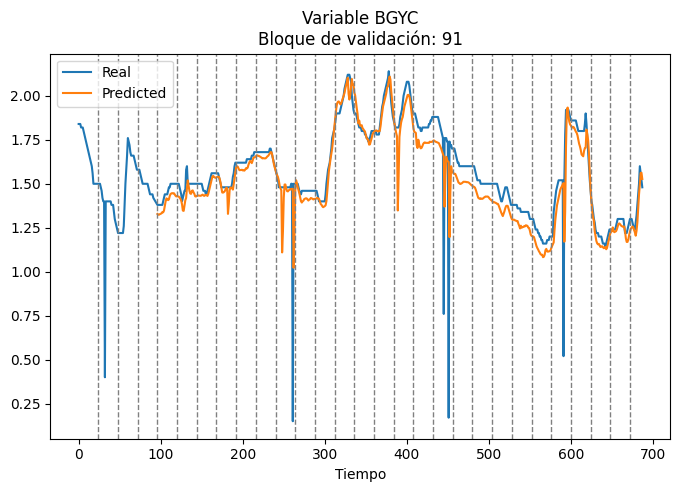

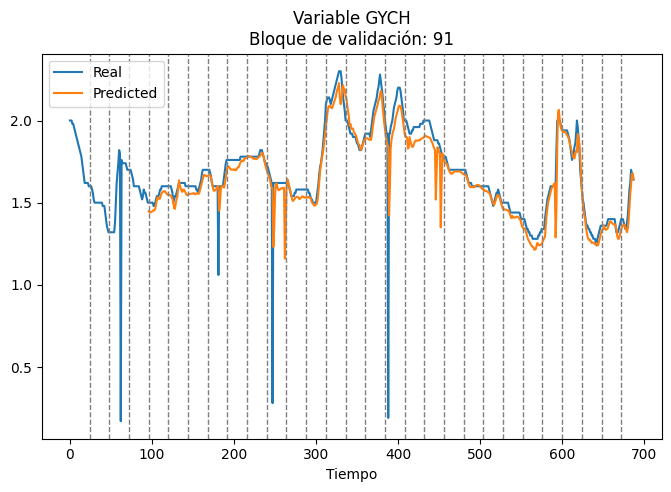

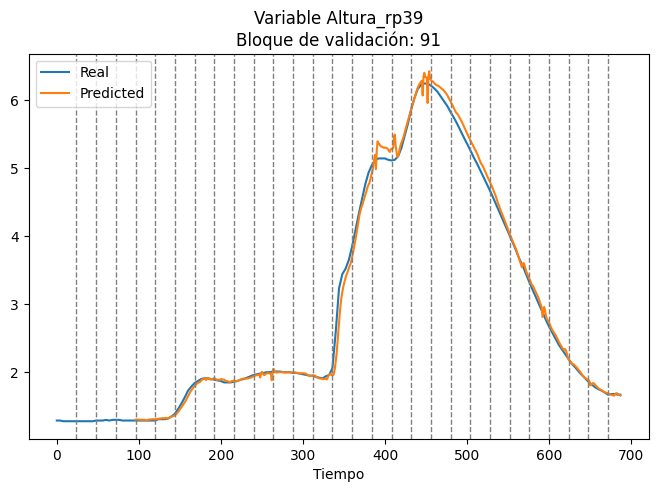

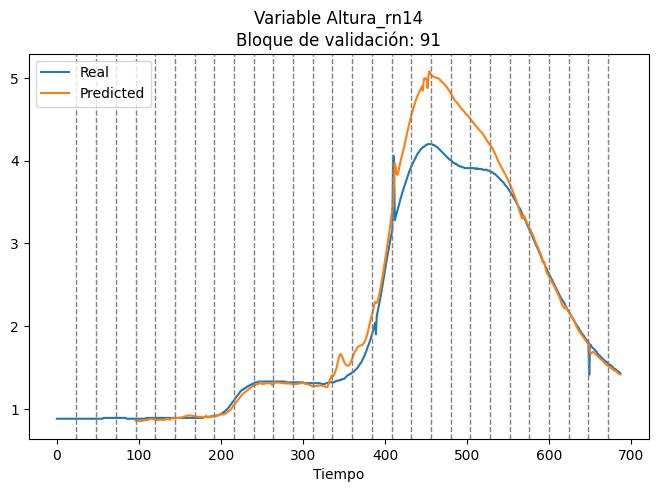

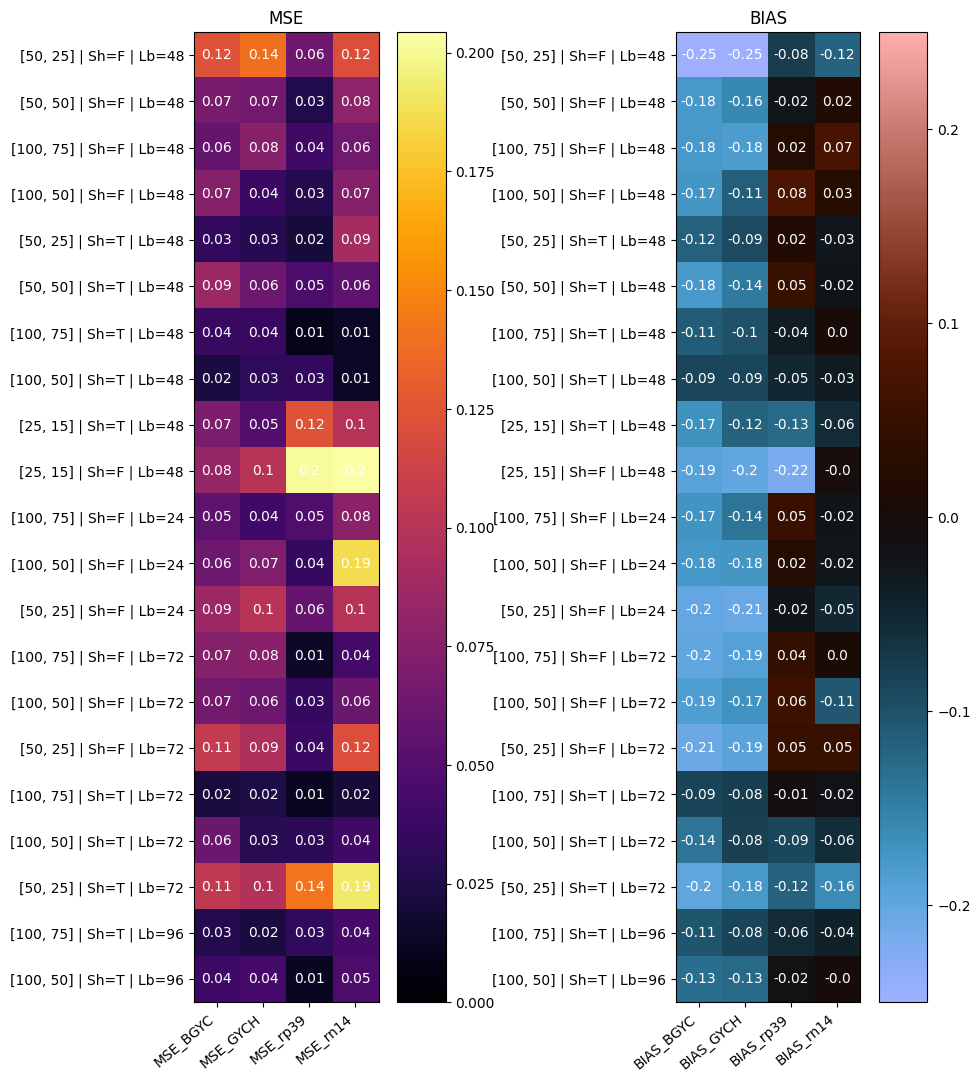

Modelo 21 guardado
***MODELO ACTUAL***
ModuleList(
  (0): CustomLSTM(
    (lstm): LSTM(11, 50, batch_first=True)
  )
  (1): CustomLSTM(
    (lstm): LSTM(50, 25, batch_first=True)
  )
)
Epoch [10/5000] - Training Loss: 0.0016, Test Loss: 0.0127
Epoch [20/5000] - Training Loss: 0.0009, Test Loss: 0.0154
Epoch [30/5000] - Training Loss: 0.0006, Test Loss: 0.0132
Epoch [40/5000] - Training Loss: 0.0005, Test Loss: 0.0104
Epoch [50/5000] - Training Loss: 0.0004, Test Loss: 0.0085
Epoch [60/5000] - Training Loss: 0.0003, Test Loss: 0.0077
Epoch [70/5000] - Training Loss: 0.0003, Test Loss: 0.0065
Epoch [80/5000] - Training Loss: 0.0002, Test Loss: 0.0055
Epoch [90/5000] - Training Loss: 0.0002, Test Loss: 0.0049
Epoch [100/5000] - Training Loss: 0.0002, Test Loss: 0.0044
Epoch [110/5000] - Training Loss: 0.0002, Test Loss: 0.0043
Epoch [120/5000] - Training Loss: 0.0002, Test Loss: 0.0040
Epoch [130/5000] - Training Loss: 0.0002, Test Loss: 0.0038
Epoch [140/5000] - Training Loss: 0.0002, Te

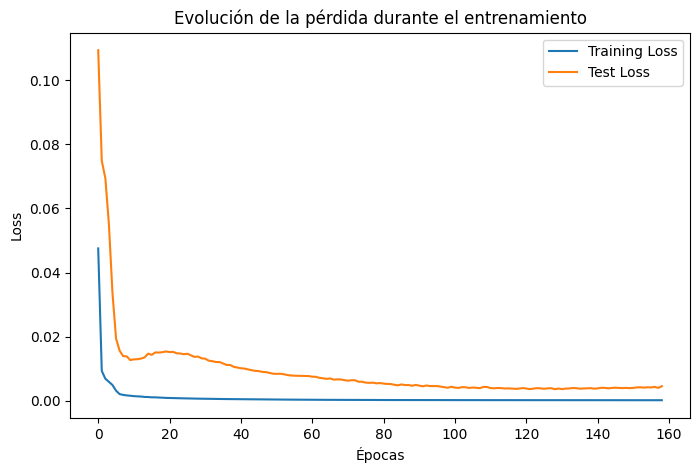

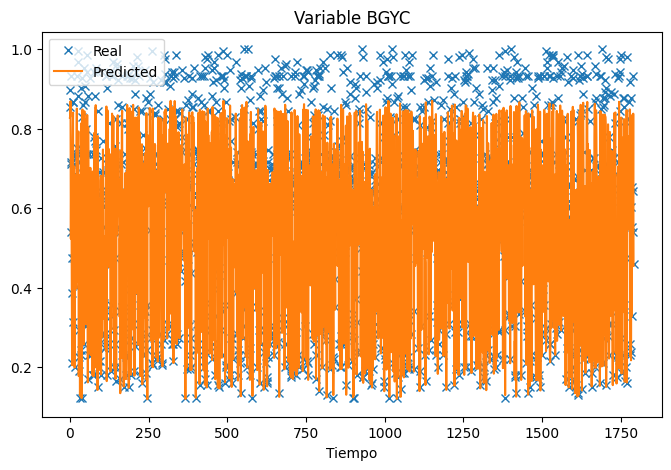

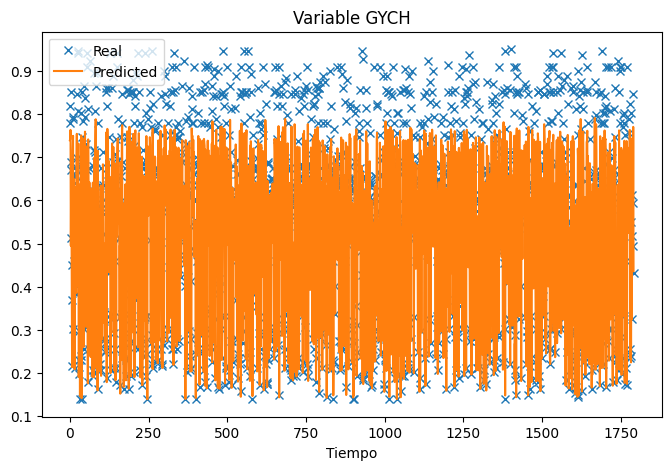

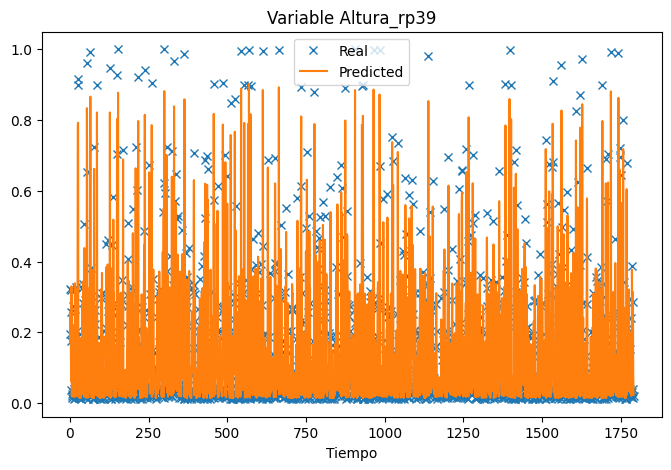

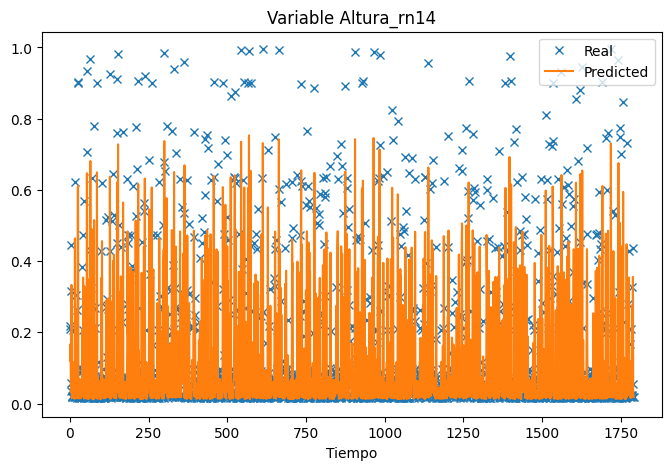

<ipython-input-13-d35cfc7a53fb>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pred_df = pd.concat([pred_df, prediction], ignore_index=True)
<ipython-input-13-d35cfc7a53fb>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.mse_validation = pd.concat([self.mse_validation, mse], ignore_index=True)
<ipython-input-13-d35cfc7a53fb>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or al

In [ ]:
for i, model in enumerate(models):
  print('***MODELO ACTUAL***')
  print(model.lstm_layers)

  loss_fn = nn.MSELoss(reduction='none')
  learning_rate_decay = 0.001
  optimizer = optim.Adam(model.parameters(), lr=learning_rate_decay)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.3)
  error_info = ErrorInfo(data, target_columns)
  early_stopping = EarlyStopping(patience=30, min_delta=0.0001)

  trainer = Trainer(model, train_loader, test_loader, loss_fn, optimizer, early_stopping, scheduler, num_epochs, device, error_info)
  trainer.train()
  trainer.plot_training()
  trainer.evaluate_on_training()
  trainer.plot_evaluation_training(target_columns)


  validator = Validator(val_data, lookback, target_columns, device)
  validator.validate()
  validator.plot_validation()

  error_info.validation_mse(validator.mse_validation, validator.bias_validation)

  plots = {**trainer.plots, **validator.plots}

  model_info = ModelInfo(model=model, propuesta=2, batch_size=batch_size, error_info=error_info, lookback=lookback, hidden_sizes=hidden_sizes[i], dropout=dropout, shuffle=shuffle, plots=plots)
  model_info.save_all()

In [ ]:
# Plot de heatmaps por ID

def prepare_heatmap(ids, metric_type):
  df = pd.read_excel('') # Leer hoja de resultados
  df = df.loc[df['ID'].isin(ids)]
  drop_cols = ['ID', 'Propuesta', 'Batch', 'Dropout', 'Capas LSTM']
  drop_cols += [c for c in df.columns if (
      ('MSE' in c if metric_type == 'BIAS' else 'BIAS' in c) or 'training' in c)]
  df = df.drop(columns=drop_cols).copy()

  # Formato de campos de configuración
  df['Lookback'] = df['Lookback'].astype(str).map(lambda x: f"Lb={x}")
  df['Shuffle'] = df['Shuffle'].map({True: 'Sh=T', False: 'Sh=F'})
  df['Index'] = df.apply(
      lambda row: f"{row['Neuronas por capa']} | {row['Shuffle']} | {row['Lookback']}", axis=1)

  df.set_index('Index', inplace=True)
  df.drop(columns=['Neuronas por capa', 'Shuffle', 'Lookback'], inplace=True)

  # Renombrar columnas
  df.columns = [f"{c[:len(metric_type)]}_{c[-4:]}" for c in df.columns]
  return df

def plot_heatmap(ids):
  d_mse = prepare_heatmap(ids, metric_type='MSE')
  d_bias = prepare_heatmap(ids, metric_type='BIAS')

  fig, axs = plt.subplots(1, 2, figsize=(11, len(d_bias)*0.6))

  for ax, data, title in zip(axs, [d_mse, d_bias], ["MSE", "BIAS"]):
    if title == "MSE":
      im = ax.imshow(data.values, cmap="inferno", vmin=0)
    else:
      v = max(abs(d_bias.values.min()), abs(d_bias.values.max()))
      im = ax.imshow(d_bias.values, cmap="berlin", vmin=-v, vmax=v)
    ax.set_title(title)
    ax.set_xticks(range(len(data.columns)))
    ax.set_xticklabels(data.columns, rotation=40, ha="right")
    ax.set_yticks(range(len(data.index)))
    ax.set_yticklabels(data.index)

    for i in range(len(data.columns)):
        for j in range(len(data.index)):
            ax.text(i, j, round(data.iloc[j, i], 2), ha="center", va="center", color="w")

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('', rotation=-90, va="bottom")

  plt.subplots_adjust(wspace=0.3)
  fig.tight_layout()
  plt.show()
  return fig

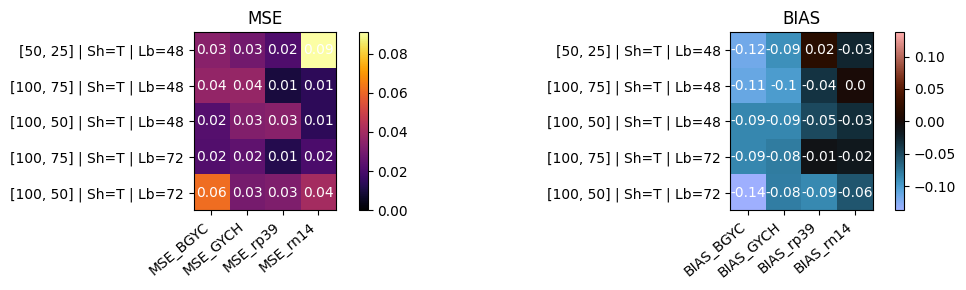

In [ ]:
ids = [5, 7, 8, 17, 18]
fig = plot_heatmap(ids)
fig.savefig('') # Guardar heatmap por ids

In [ ]:
input_columns = ['Altura_rp39', 'Altura_rn14', 'GYCH', 'BGYC', 'Velocidad_viento_wind_guru_nandubaysal', 'Direccion_viento_wind_guru_nandubaysal', 'Lluvia_wind_guru_nandubaysal',
                 'Velocidad_viento_wind_guru_san_justo', 'Direccion_viento_wind_guru_san_justo', 'Lluvia_wind_guru_san_justo', 'Altura_nueva_palmira']

target_columns = ['BGYC', 'GYCH', 'Altura_rp39', 'Altura_rn14']

/tmp/ipython-input-359422460.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pred_df = pd.concat([pred_df, prediction])
/tmp/ipython-input-359422460.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.mse_validation = pd.concat([self.mse_validation, mse], ignore_index=True)
/tmp/ipython-input-359422460.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when d

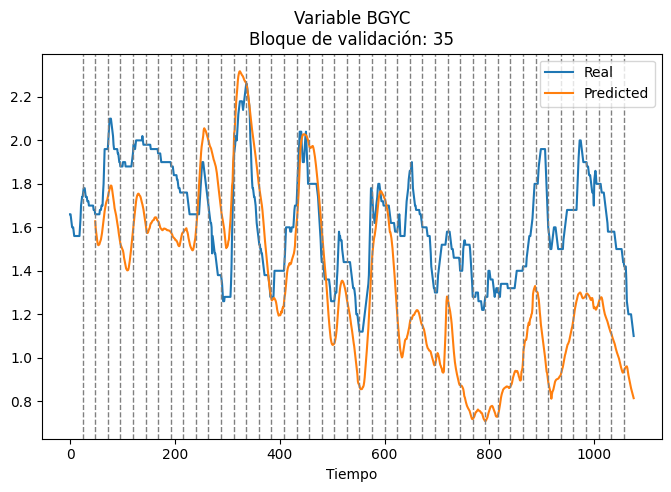

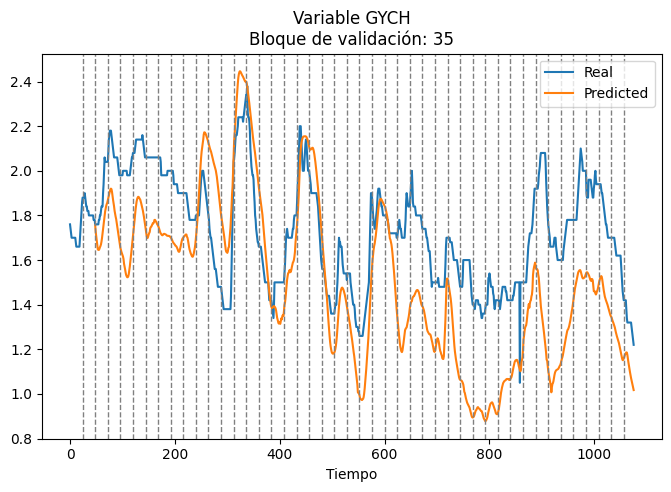

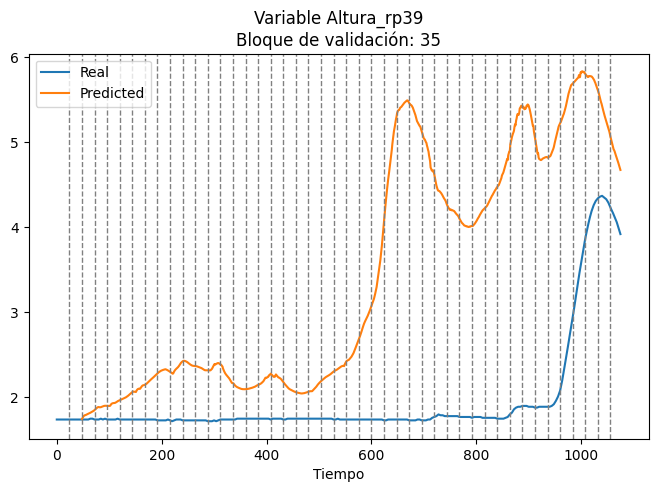

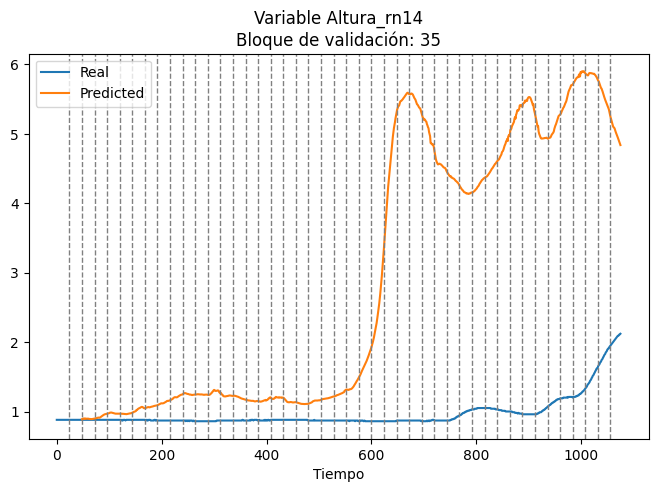

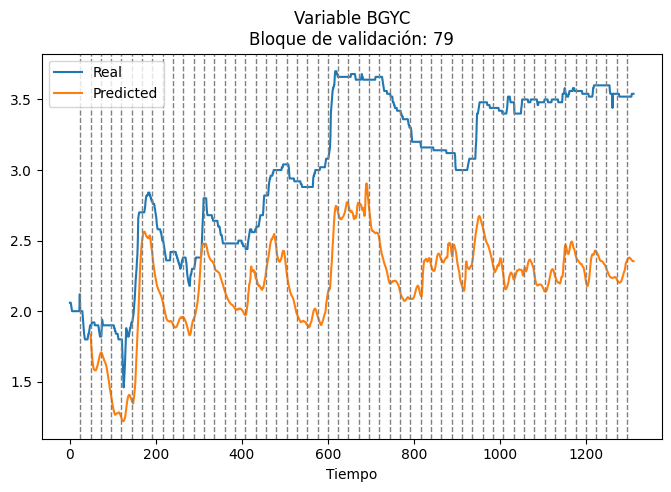

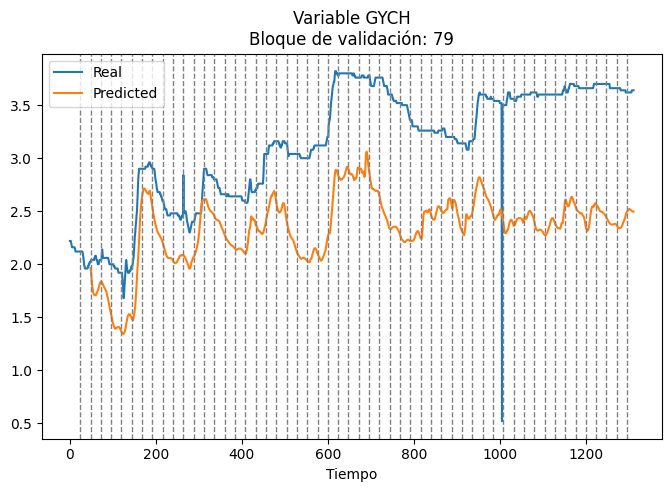

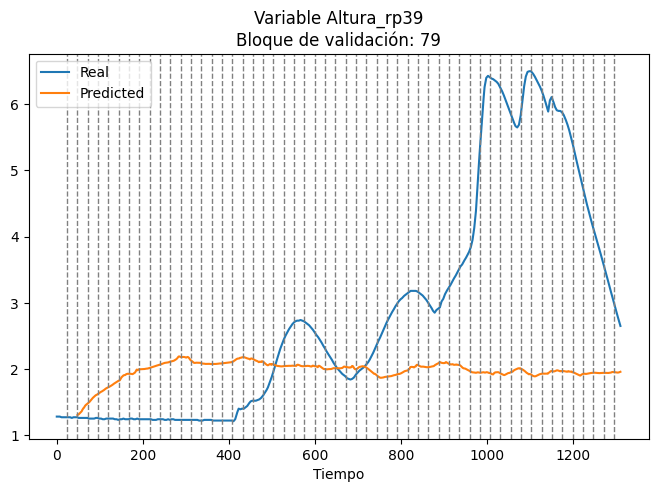

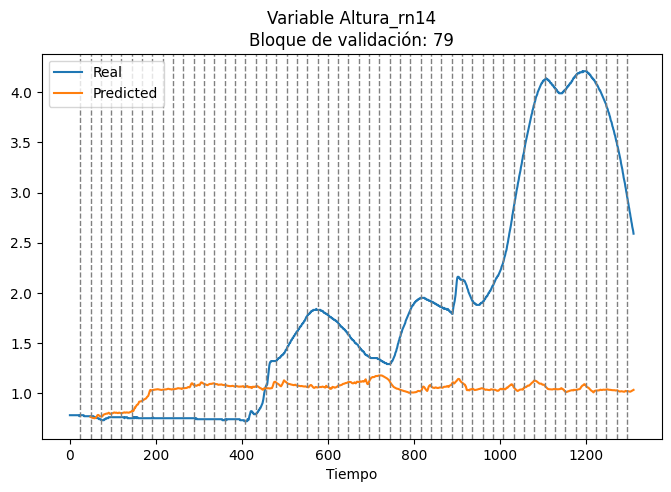

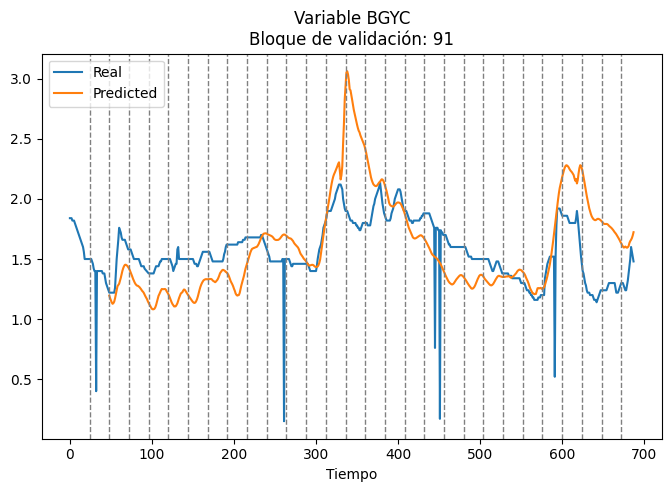

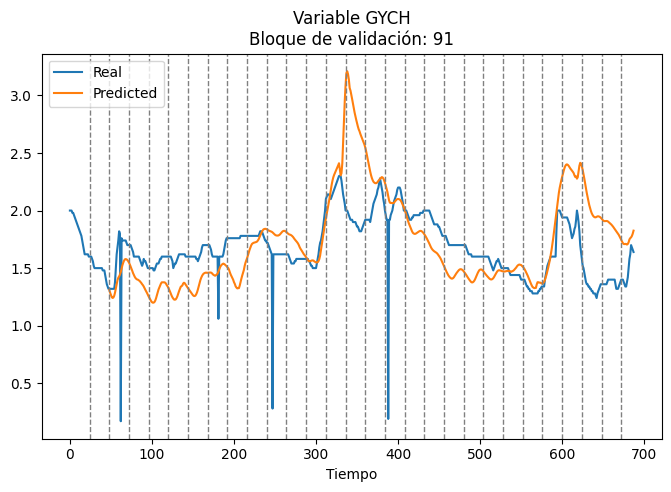

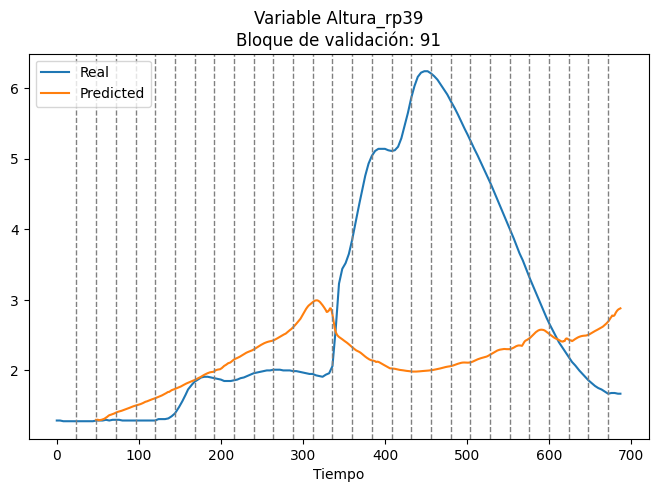

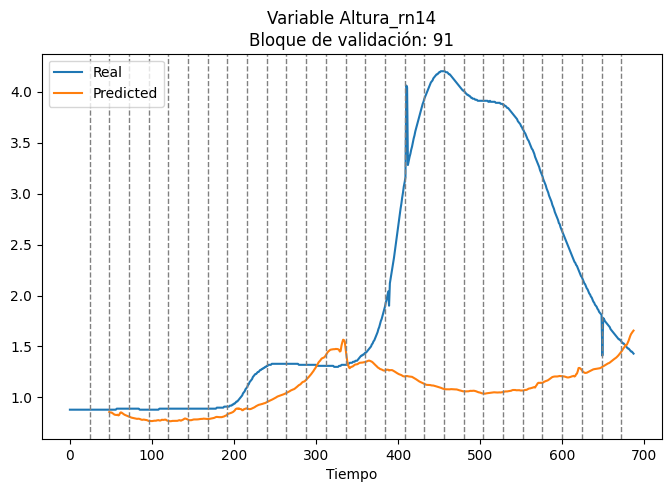

In [ ]:
lookback = 48
device = torch.device('cpu')
validator = Validator(val_data, lookback, target_columns, device)
validator.validate()
validator.plot_validation()